In [1]:
path = "data/raw_data/P01/"
# perfect: 3,4,5,6
# pay attention:
# - 1,2 timestamp issues?

**Schedule**

1. Load Isoforce data and extract torque segments.
2. Load Isoforce data recorded with Python and extract torque segments with time stamps.
3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data.
4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values.

In [2]:
import os
from glob import glob
from os.path import join

import matplotlib.pyplot as plt
import numpy as np

from tools import (
    IsoforceIso,
    IsoforcePy,
    ProcessingDir,
    Protocol,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
    sync_NI_PY_times,
)

_1. Load Isoforce data and extract torque segments._

Fund participant data:

Head directory: self.path='data/raw_data/P01/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P01/EIT_P01_raw_data_12012025114030.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P01/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P01/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P01/eit_raw/20250218 17.03.01/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P01/EIT_processed/'
[70 70 80 80 40 40 30 30 20 20 60 60 50 50]
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


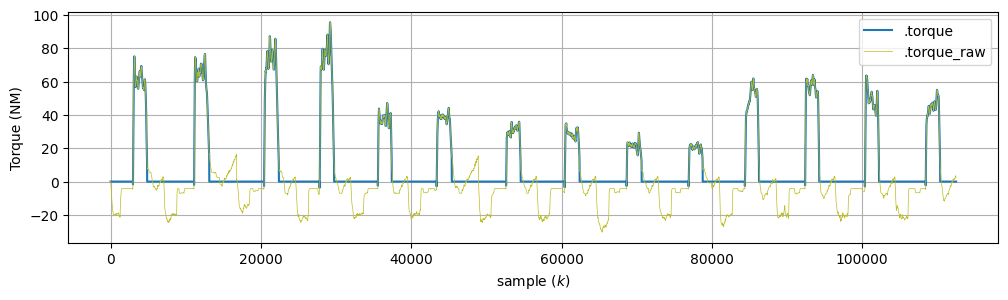

In [3]:
part_path = ProcessingDir(path)
protocol = Protocol(part_path.path, prints=False)
print(protocol.IsokinetikMeasurement.force_levels)

DF = renderDF(part_path.isoforce_iso)

isoforce_iso = IsoforceIso(DF, protocol, LP_filter=True)
isoforce_iso.plot_torque()

_2. Load Isoforce data recorded with Python and extract torque segments with time stamps._

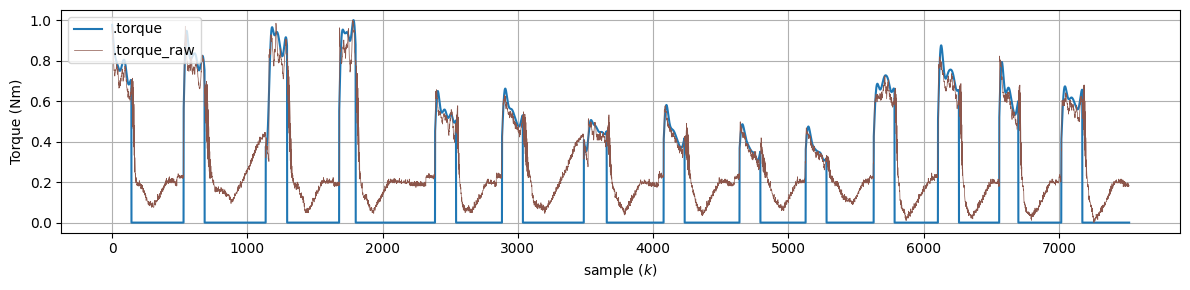

In [4]:
isoforce_py = IsoforcePy(
    part_path.isoforce_py_raw,
    protocol,
    LP_filter=True,
    over_UTC=False,
    scale_0_1=True,
    segment_len_threshold=20,
)
isoforce_py.plot_torque()

_3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data._

In [5]:
assert len(isoforce_iso.torque_segments.keys()) == len(
    isoforce_py.torque_segments.keys()
)

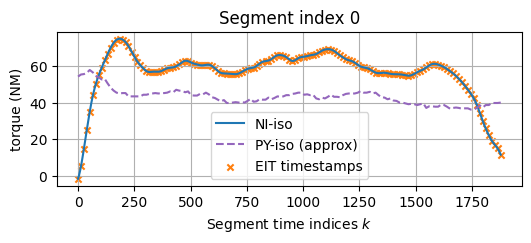

In [6]:
tmp_ts_seg, sampled_iso = sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx=0, plotting=True
)

_4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values._

In [7]:
from tools import (
    find_best_match,
    find_closest_index,
    load_eit_npz,
    sync_eit_ISO_segments,
)

In [8]:
times_eit, eit = load_eit_npz(part_path)

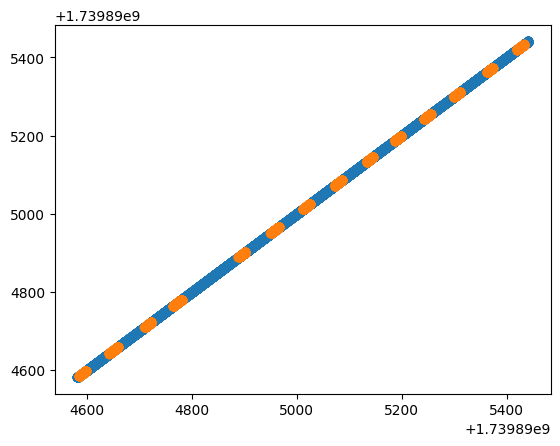

In [9]:
plt.scatter(times_eit, times_eit)
timestamps = np.array([dt.timestamp() for dt in isoforce_py.time], dtype=float)
plt.scatter(timestamps, timestamps)

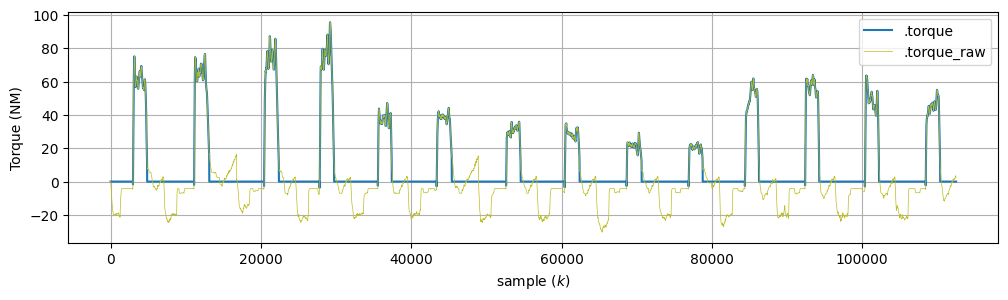

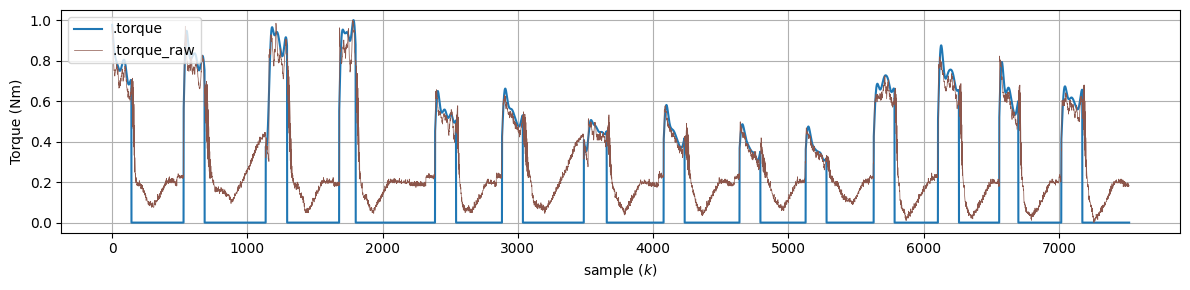

In [10]:
isoforce_iso.plot_torque()
isoforce_py.plot_torque()

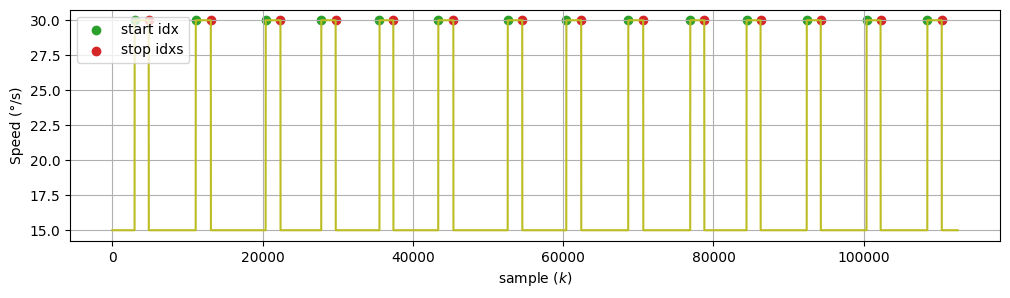

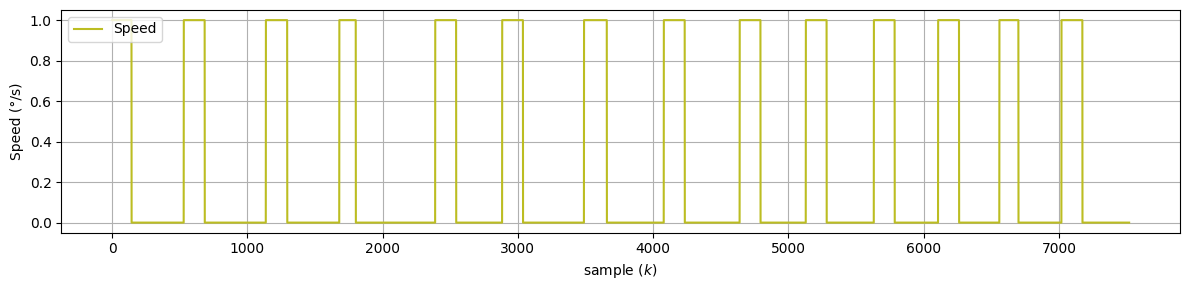

In [11]:
isoforce_iso.plot_speed()
isoforce_py.plot_speed()

Loading eit...
Matching sequences...


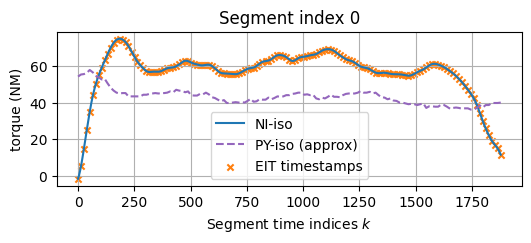

detected start idx valuessync_lst[0]=153, times_eit[sync_lst[0]]=1739894586.008
153 diff start: -0.007999897003173828 diff end: -0.00800013542175293


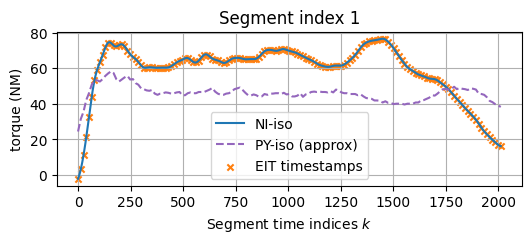

detected start idx valuessync_lst[0]=2482, times_eit[sync_lst[0]]=1739894644.23
2482 diff start: -0.005000114440917969 diff end: -0.004999876022338867


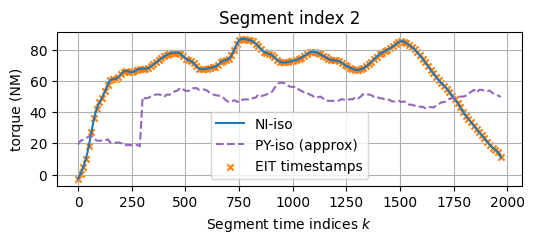

detected start idx valuessync_lst[0]=3089, times_eit[sync_lst[0]]=1739894659.404
3089 diff start: -0.003999948501586914 diff end: -0.0019998550415039062


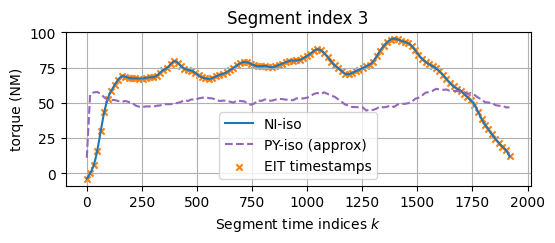

detected start idx valuessync_lst[0]=5632, times_eit[sync_lst[0]]=1739894722.977
5632 diff start: -0.002000093460083008 diff end: 0.0009999275207519531


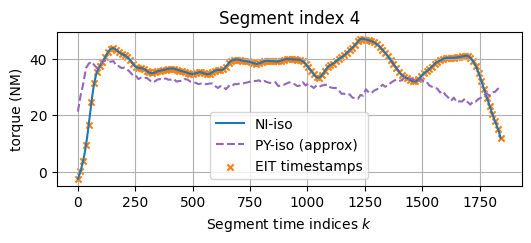

detected start idx valuessync_lst[0]=12341, times_eit[sync_lst[0]]=1739894890.693
12341 diff start: 0.006999969482421875 diff end: 0.006999969482421875


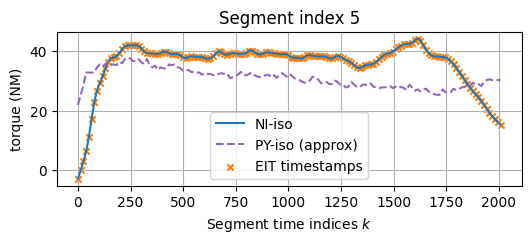

detected start idx valuessync_lst[0]=14756, times_eit[sync_lst[0]]=1739894951.065
14756 diff start: 0.009999990463256836 diff end: 0.009999990463256836


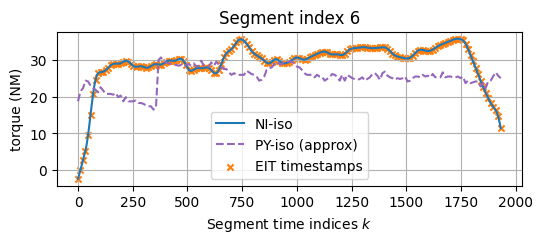

detected start idx valuessync_lst[0]=15361, times_eit[sync_lst[0]]=1739894966.19
15361 diff start: 0.009999990463256836 diff end: -0.011999845504760742


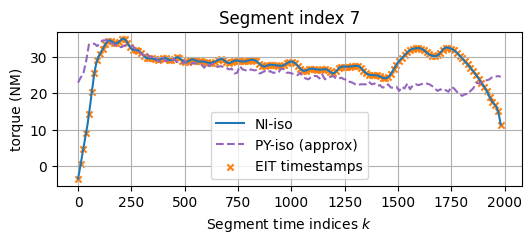

detected start idx valuessync_lst[0]=19632, times_eit[sync_lst[0]]=1739895072.959
19632 diff start: -0.009000062942504883 diff end: -0.009000062942504883


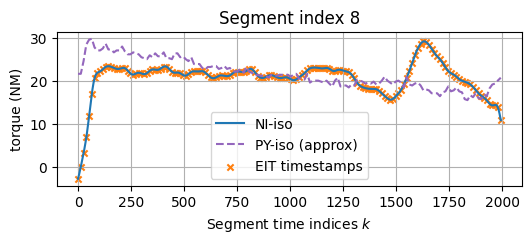

detected start idx valuessync_lst[0]=22073, times_eit[sync_lst[0]]=1739895133.981
22073 diff start: -0.006000041961669922 diff end: -0.006000041961669922


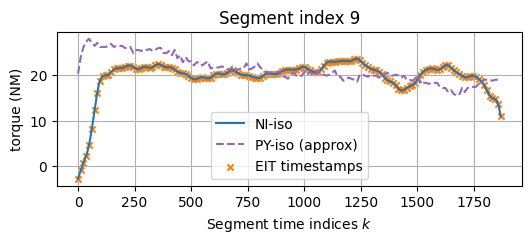

detected start idx valuessync_lst[0]=24202, times_eit[sync_lst[0]]=1739895187.203
24202 diff start: -0.003000020980834961 diff end: -0.003000020980834961


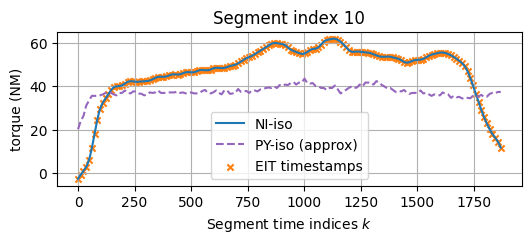

detected start idx valuessync_lst[0]=26465, times_eit[sync_lst[0]]=1739895243.775
26465 diff start: 0.0 diff end: 0.0


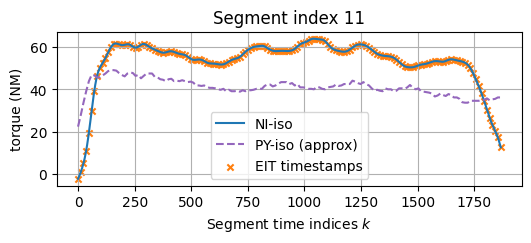

detected start idx valuessync_lst[0]=28700, times_eit[sync_lst[0]]=1739895299.647
28700 diff start: 0.003000020980834961 diff end: 0.003000020980834961


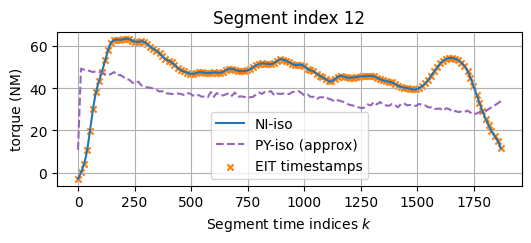

detected start idx valuessync_lst[0]=29153, times_eit[sync_lst[0]]=1739895310.972
29153 diff start: 0.003000020980834961 diff end: 0.00599980354309082


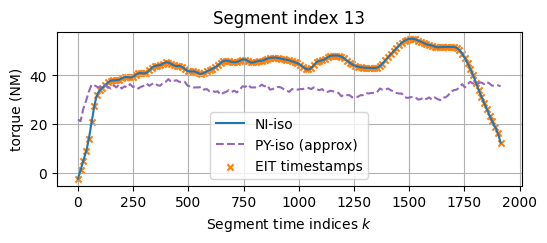

detected start idx valuessync_lst[0]=33532, times_eit[sync_lst[0]]=1739895420.441
33532 diff start: 0.009000062942504883 diff end: 0.009000062942504883


In [12]:
EIT, TORQUE, TS_iso, TS_eit = sync_eit_ISO_segments(
    part_path, isoforce_iso, isoforce_py
)

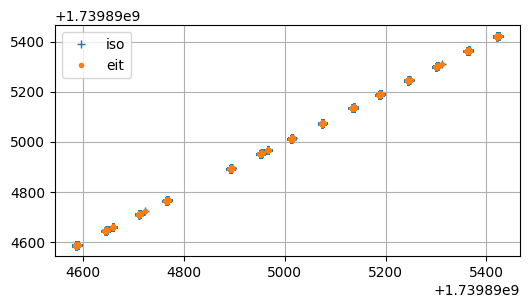

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(TS_iso, TS_iso, "+", label="iso")
plt.plot(TS_eit, TS_eit, ".", label="eit")
plt.legend()
plt.grid()
plt.show()

**Export**

1 20
From: data/raw_data/P01/
To: data/prepared_data/P01/
Fund participant data:

Head directory: self.path='data/raw_data/P01/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P01/EIT_P01_raw_data_12012025114030.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P01/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P01/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P01/eit_raw/20250218 17.03.01/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P01/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


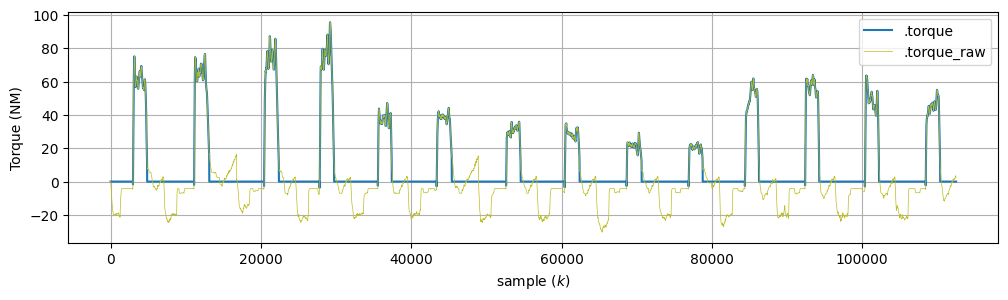

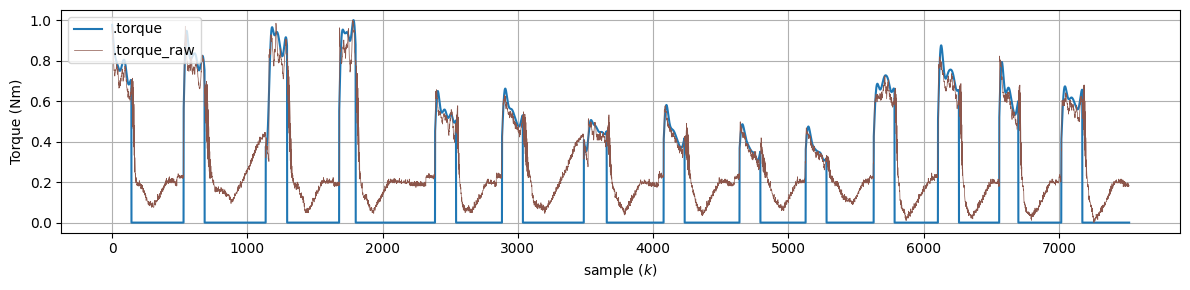

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=153, times_eit[sync_lst[0]]=1739894586.008
153 diff start: -0.007999897003173828 diff end: -0.00800013542175293
detected start idx valuessync_lst[0]=2482, times_eit[sync_lst[0]]=1739894644.23
2482 diff start: -0.005000114440917969 diff end: -0.004999876022338867
detected start idx valuessync_lst[0]=3089, times_eit[sync_lst[0]]=1739894659.404
3089 diff start: -0.003999948501586914 diff end: -0.0019998550415039062
detected start idx valuessync_lst[0]=5632, times_eit[sync_lst[0]]=1739894722.977
5632 diff start: -0.002000093460083008 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=12341, times_eit[sync_lst[0]]=1739894890.693
12341 diff start: 0.006999969482421875 diff end: 0.006999969482421875
detected start idx valuessync_lst[0]=14756, times_eit[sync_lst[0]]=1739894951.065
14756 diff start: 0.009999990463256836 diff end: 0.009999990463256836
detected start idx valuessync_lst[0]=15361, times_eit[

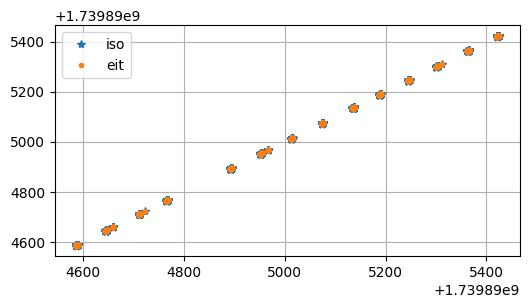

Export data (y) y


2 20
From: data/raw_data/P02/
To: data/prepared_data/P02/
Fund participant data:

Head directory: self.path='data/raw_data/P02/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P02/EIT_P02_raw_data_12012025141003.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P02/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P02/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P02/eit_raw/20250219 09.58.20/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P02/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


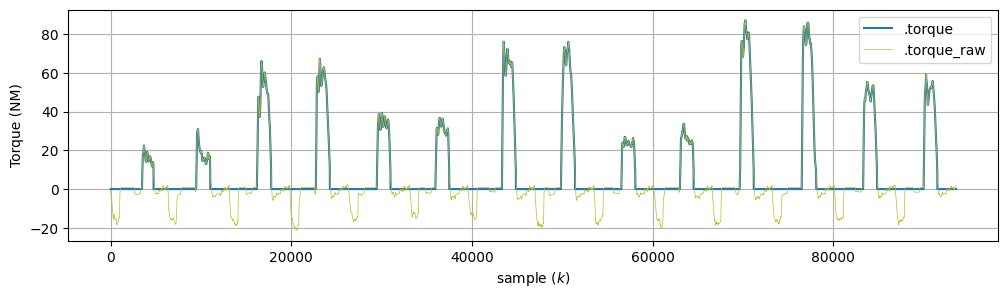

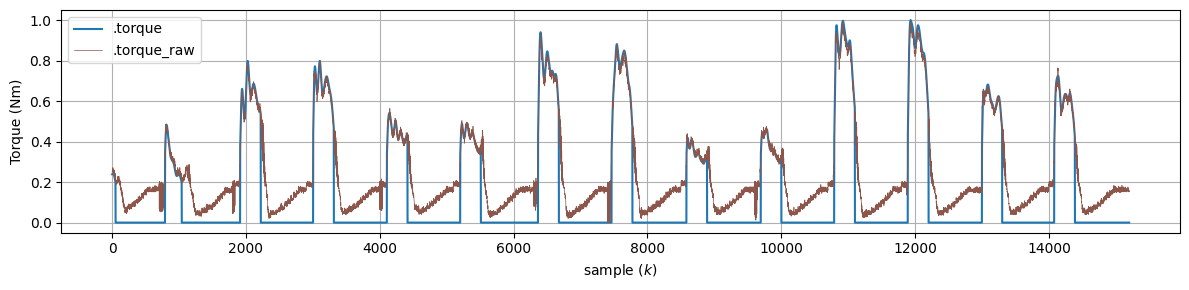

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=5, times_eit[sync_lst[0]]=1739955501.008
5 diff start: -0.007999897003173828 diff end: -0.007999897003173828
detected start idx valuessync_lst[0]=2081, times_eit[sync_lst[0]]=1739955552.906
2081 diff start: 0.004000186920166016 diff end: 0.009999990463256836
detected start idx valuessync_lst[0]=4130, times_eit[sync_lst[0]]=1739955604.128
4130 diff start: 0.002000093460083008 diff end: -0.003000020980834961
detected start idx valuessync_lst[0]=6327, times_eit[sync_lst[0]]=1739955659.05
6327 diff start: -0.009999990463256836 diff end: -0.005000114440917969
detected start idx valuessync_lst[0]=8447, times_eit[sync_lst[0]]=1739955712.048
8447 diff start: 0.011999845504760742 diff end: 0.0070002079010009766
detected start idx valuessync_lst[0]=10886, times_eit[sync_lst[0]]=1739955773.02
10886 diff start: 0.0 diff end: -0.005000114440917969
detected start idx valuessync_lst[0]=12991, times_eit[sync_lst[0]]=1739955825.6

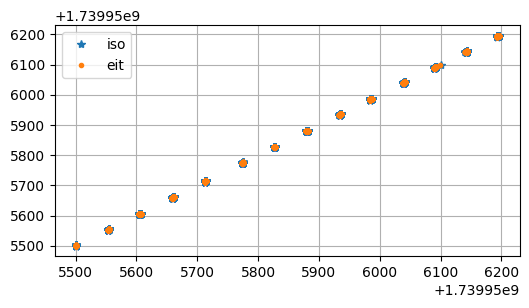

Export data (y) y


3 100
From: data/raw_data/P03/
To: data/prepared_data/P03/
Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


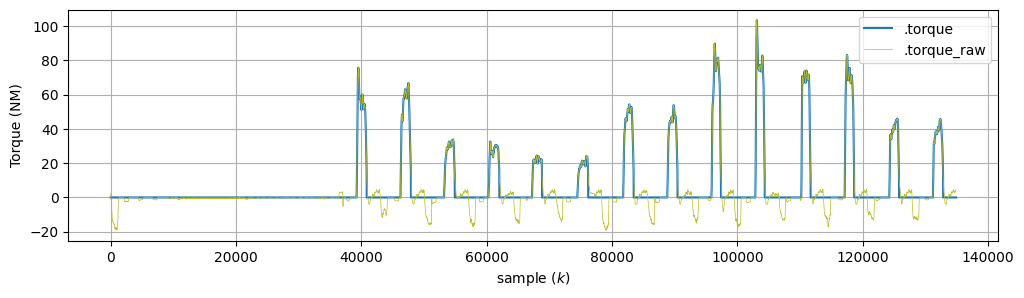

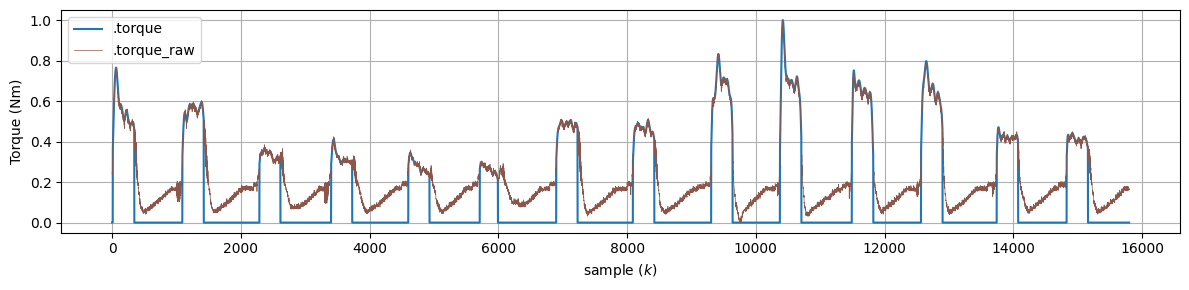

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=982, times_eit[sync_lst[0]]=1739957543.097
982 diff start: 0.003000020980834961 diff end: 0.00800013542175293
detected start idx valuessync_lst[0]=3095, times_eit[sync_lst[0]]=1739957595.919
3095 diff start: -0.008999824523925781 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=5254, times_eit[sync_lst[0]]=1739957649.891
5254 diff start: -0.010999917984008789 diff end: -0.010999917984008789
detected start idx valuessync_lst[0]=7339, times_eit[sync_lst[0]]=1739957702.014
7339 diff start: 0.006000041961669922 diff end: -0.00800013542175293
detected start idx valuessync_lst[0]=9499, times_eit[sync_lst[0]]=1739957756.011
9499 diff start: -0.0009999275207519531 diff end: 0.003999948501586914
detected start idx valuessync_lst[0]=11863, times_eit[sync_lst[0]]=1739957815.108
11863 diff start: 0.0019998550415039062 diff end: -0.011999845504760742
detected start idx valuessync_lst[0]=14018, times_eit[sy

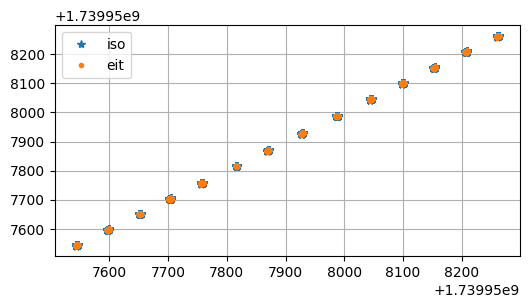

Export data (y) y


4 100
From: data/raw_data/P04/
To: data/prepared_data/P04/
Fund participant data:

Head directory: self.path='data/raw_data/P04/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P04/EIT_P04_raw_data_12012025170231.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P04/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P04/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P04/eit_raw/20250219 13.24.33/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P04/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


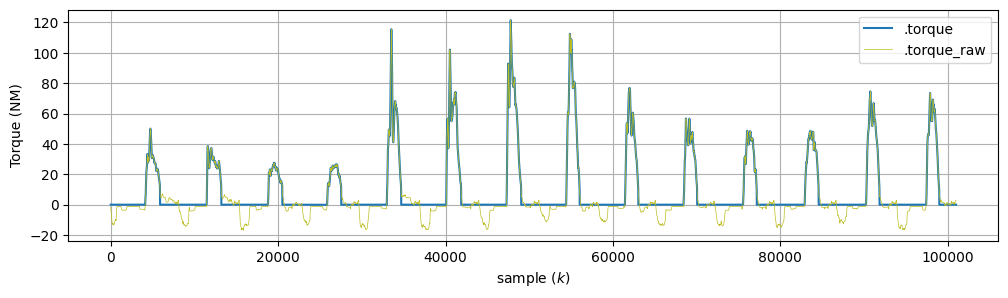

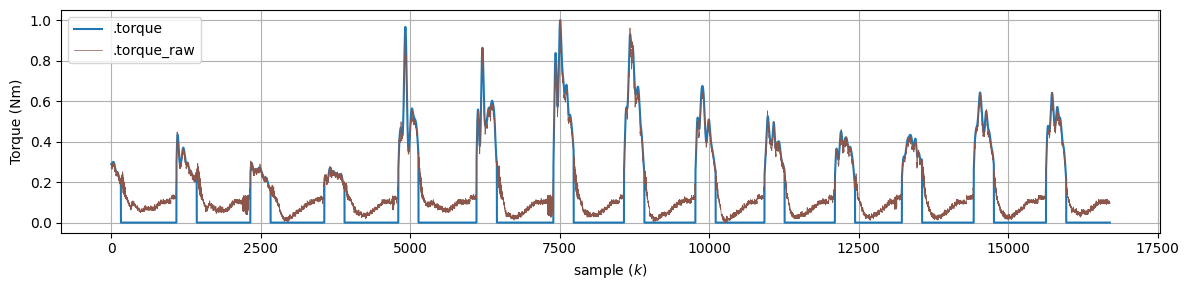

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=168, times_eit[sync_lst[0]]=1739967877.993
168 diff start: 0.006999969482421875 diff end: -0.00800013542175293
detected start idx valuessync_lst[0]=2445, times_eit[sync_lst[0]]=1739967934.915
2445 diff start: -0.004999876022338867 diff end: 0.0
detected start idx valuessync_lst[0]=4659, times_eit[sync_lst[0]]=1739967990.262
4659 diff start: 0.007999897003173828 diff end: 0.003000020980834961
detected start idx valuessync_lst[0]=6754, times_eit[sync_lst[0]]=1739968042.635
6754 diff start: 0.005000114440917969 diff end: -0.009999990463256836
detected start idx valuessync_lst[0]=8929, times_eit[sync_lst[0]]=1739968097.007
8929 diff start: 0.003000020980834961 diff end: -0.012000083923339844
detected start idx valuessync_lst[0]=11332, times_eit[sync_lst[0]]=1739968157.079
11332 diff start: 0.010999917984008789 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=13967, times_eit[sync_lst[0]]=173996822

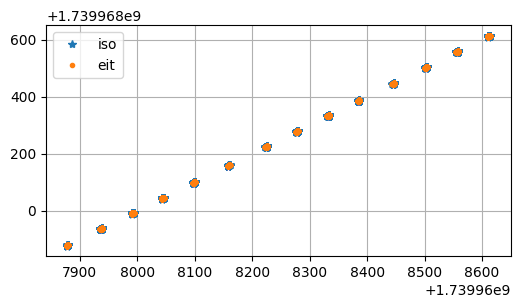

Export data (y) y


5 100
From: data/raw_data/P05/
To: data/prepared_data/P05/
Fund participant data:

Head directory: self.path='data/raw_data/P05/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P05/EIT_P05_raw_data_12012025183335.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P05/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P05/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P05/eit_raw/20250219 14.53.55/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P05/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


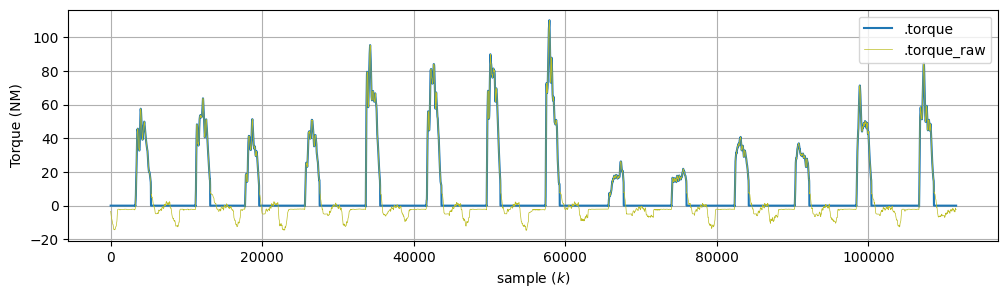

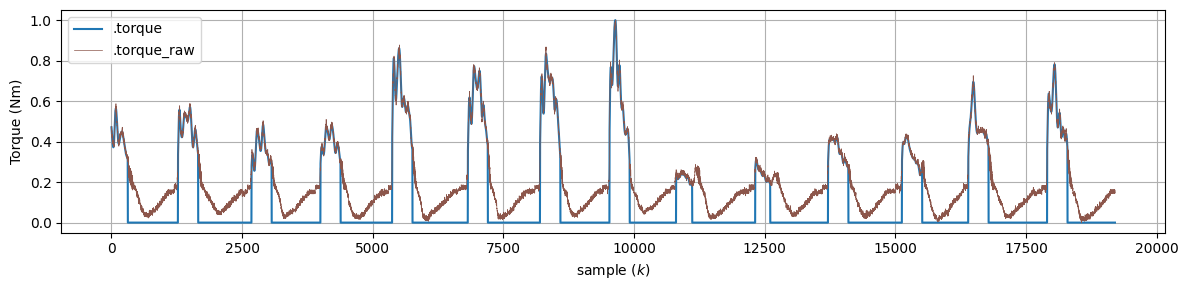

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=223, times_eit[sync_lst[0]]=1739973242.009
223 diff start: -0.009000062942504883 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=2532, times_eit[sync_lst[0]]=1739973299.731
2532 diff start: -0.010999917984008789 diff end: -0.01100015640258789
detected start idx valuessync_lst[0]=4894, times_eit[sync_lst[0]]=1739973358.778
4894 diff start: 0.011999845504760742 diff end: 0.002000093460083008
detected start idx valuessync_lst[0]=7182, times_eit[sync_lst[0]]=1739973415.975
7182 diff start: 0.005000114440917969 diff end: -0.005000114440917969
detected start idx valuessync_lst[0]=9451, times_eit[sync_lst[0]]=1739973472.697
9451 diff start: 0.003000020980834961 diff end: -0.002000093460083008
detected start idx valuessync_lst[0]=11630, times_eit[sync_lst[0]]=1739973527.169
11630 diff start: 0.01100015640258789 diff end: -0.003999948501586914
detected start idx valuessync_lst[0]=13943, times_eit[sync

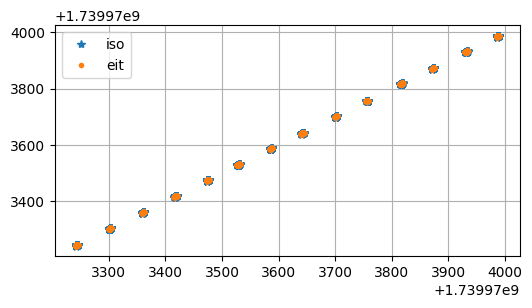

Export data (y) y


6 100
From: data/raw_data/P06/
To: data/prepared_data/P06/
Fund participant data:

Head directory: self.path='data/raw_data/P06/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P06/EIT_P06_raw_data_12012025202214.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P06/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P06/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P06/eit_raw/20250219 16.39.42/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P06/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


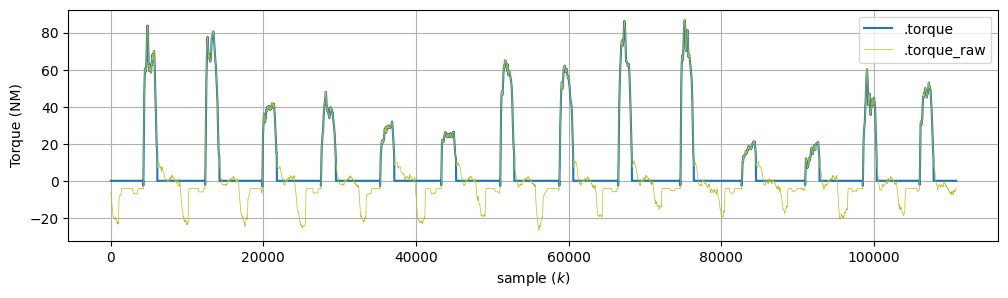

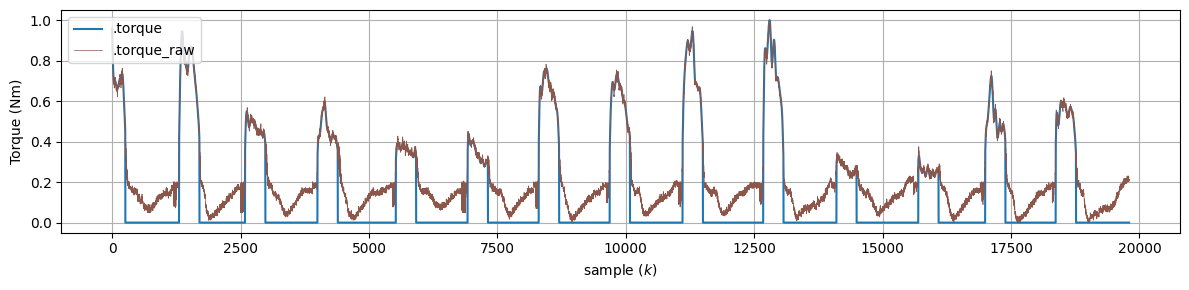

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=127, times_eit[sync_lst[0]]=1739979585.99
127 diff start: 0.009999990463256836 diff end: 0.009999990463256836
detected start idx valuessync_lst[0]=2529, times_eit[sync_lst[0]]=1739979646.037
2529 diff start: -0.006999969482421875 diff end: -0.006999969482421875
detected start idx valuessync_lst[0]=5122, times_eit[sync_lst[0]]=1739979710.859
5122 diff start: 0.010999917984008789 diff end: 0.0019998550415039062
detected start idx valuessync_lst[0]=7287, times_eit[sync_lst[0]]=1739979764.981
7287 diff start: -0.010999917984008789 diff end: 0.004000186920166016
detected start idx valuessync_lst[0]=9617, times_eit[sync_lst[0]]=1739979823.228
9617 diff start: 0.002000093460083008 diff end: 0.006999969482421875
detected start idx valuessync_lst[0]=12176, times_eit[sync_lst[0]]=1739979887.2
12176 diff start: 0.0 diff end: -0.008999824523925781
detected start idx valuessync_lst[0]=14890, times_eit[sync_lst[0]]=1739979955.

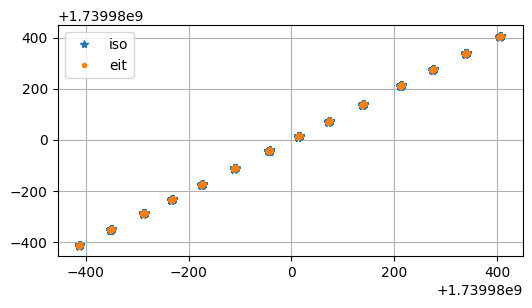

Export data (y) y


7 105
From: data/raw_data/P07/
To: data/prepared_data/P07/
Fund participant data:

Head directory: self.path='data/raw_data/P07/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P07/EIT_P07_raw_data_12012025214154.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P07/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P07/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P07/eit_raw/20250220 16.27.13/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P07/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


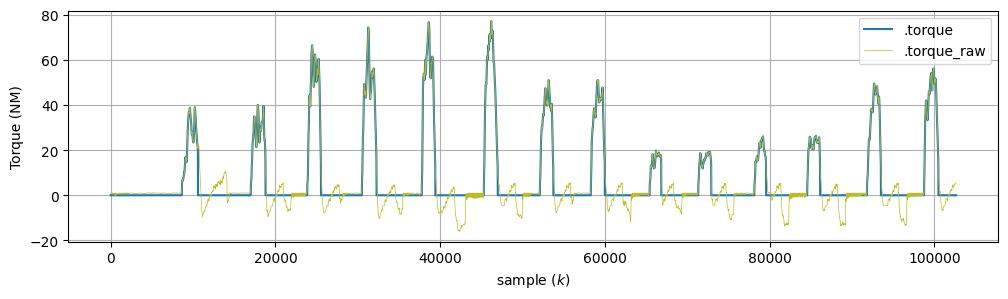

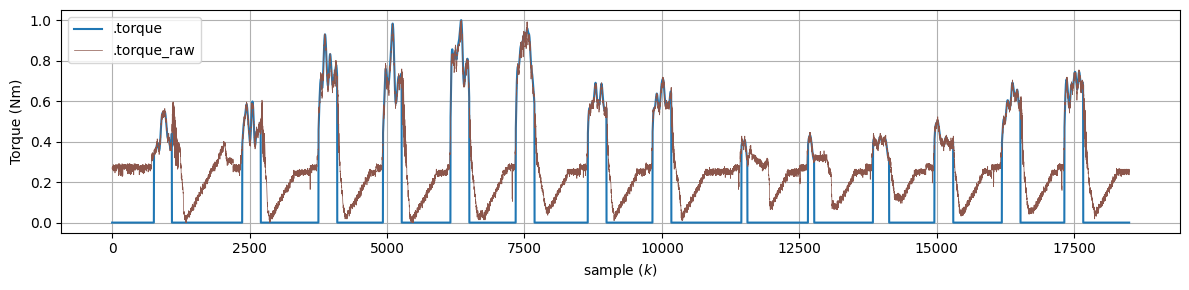

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=120, times_eit[sync_lst[0]]=1740065237.601
120 diff start: -0.0010001659393310547 diff end: -0.0010001659393310547
detected start idx valuessync_lst[0]=2282, times_eit[sync_lst[0]]=1740065291.648
2282 diff start: 0.012000083923339844 diff end: -0.003000020980834961
detected start idx valuessync_lst[0]=4757, times_eit[sync_lst[0]]=1740065353.52
4757 diff start: 0.009999990463256836 diff end: 0.0
detected start idx valuessync_lst[0]=7627, times_eit[sync_lst[0]]=1740065425.266
7627 diff start: -0.006000041961669922 diff end: 0.009000062942504883
detected start idx valuessync_lst[0]=9718, times_eit[sync_lst[0]]=1740065477.538
9718 diff start: 0.0019998550415039062 diff end: 0.012000083923339844
detected start idx valuessync_lst[0]=11753, times_eit[sync_lst[0]]=1740065528.41
11753 diff start: 0.0 diff end: 0.0
detected start idx valuessync_lst[0]=14438, times_eit[sync_lst[0]]=1740065595.532
14438 diff start: -0.012000

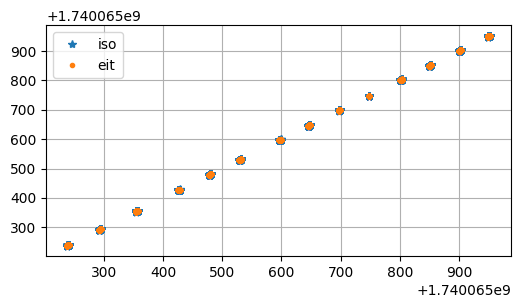

Export data (y) y


9 105
From: data/raw_data/P09/
To: data/prepared_data/P09/
Fund participant data:

Head directory: self.path='data/raw_data/P09/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P09/EIT_P09_raw_data_13012025020741.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P09/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P09/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P09/eit_raw/20250224 12.31.44/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P09/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


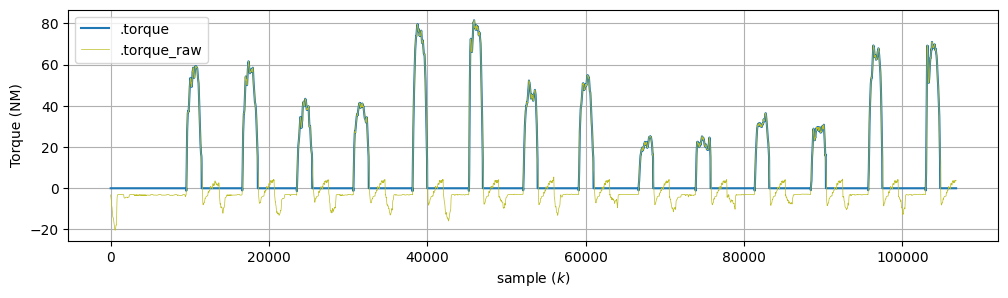

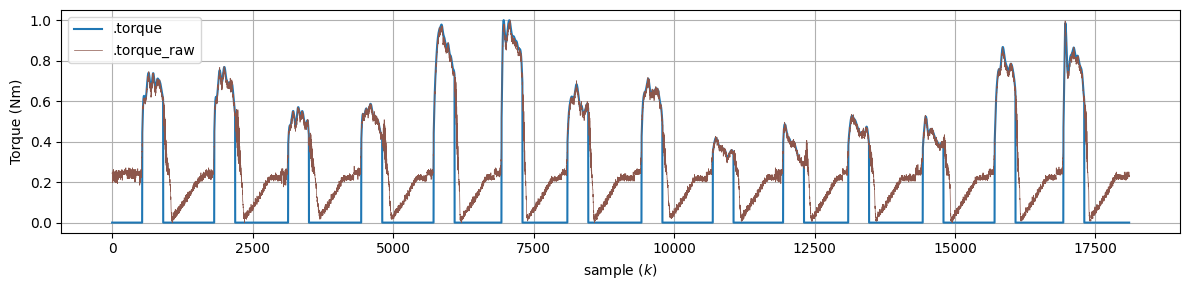

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=264, times_eit[sync_lst[0]]=1740396711.345
264 diff start: 0.004999876022338867 diff end: 0.0
detected start idx valuessync_lst[0]=2457, times_eit[sync_lst[0]]=1740396766.167
2457 diff start: 0.003000020980834961 diff end: -0.011999845504760742
detected start idx valuessync_lst[0]=4543, times_eit[sync_lst[0]]=1740396818.315
4543 diff start: 0.004999876022338867 diff end: -0.003999948501586914
detected start idx valuessync_lst[0]=6584, times_eit[sync_lst[0]]=1740396869.337
6584 diff start: -0.006999969482421875 diff end: -0.012000083923339844
detected start idx valuessync_lst[0]=8659, times_eit[sync_lst[0]]=1740396921.21
8659 diff start: 0.0 diff end: -0.003999948501586914
detected start idx valuessync_lst[0]=10662, times_eit[sync_lst[0]]=1740396971.282
10662 diff start: 0.007999897003173828 diff end: 0.003000020980834961
detected start idx valuessync_lst[0]=12852, times_eit[sync_lst[0]]=1740397026.029
12852 diff 

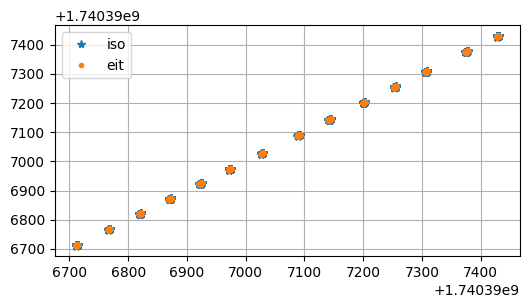

Export data (y) y


10 105
From: data/raw_data/P10/
To: data/prepared_data/P10/
Fund participant data:

Head directory: self.path='data/raw_data/P10/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P10/EIT_P10_raw_data_13012025045941.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P10/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P10/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P10/eit_raw/20250225 14.37.03/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P10/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


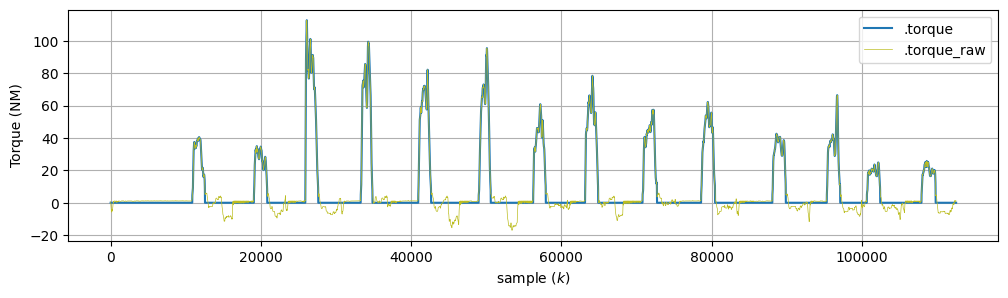

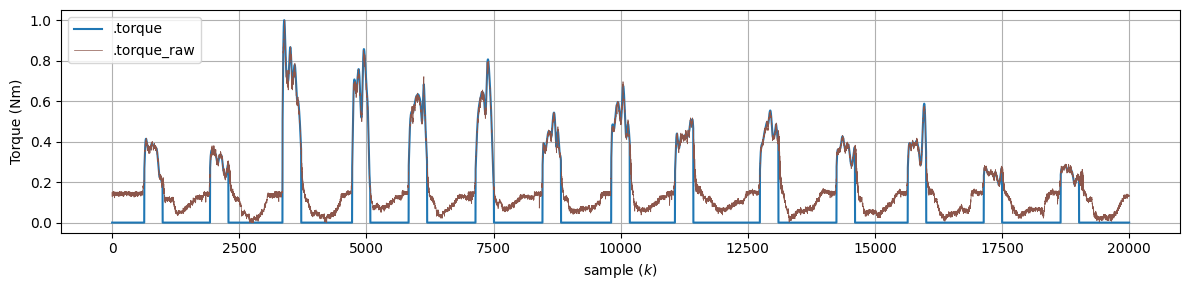

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=831, times_eit[sync_lst[0]]=1740490645.322
831 diff start: -0.002000093460083008 diff end: -0.011999845504760742
detected start idx valuessync_lst[0]=3308, times_eit[sync_lst[0]]=1740490707.244
3308 diff start: 0.006000041961669922 diff end: 0.00599980354309082
detected start idx valuessync_lst[0]=5518, times_eit[sync_lst[0]]=1740490762.491
5518 diff start: 0.009000062942504883 diff end: -0.00599980354309082
detected start idx valuessync_lst[0]=7586, times_eit[sync_lst[0]]=1740490814.188
7586 diff start: 0.002000093460083008 diff end: 0.012000083923339844
detected start idx valuessync_lst[0]=9751, times_eit[sync_lst[0]]=1740490868.311
9751 diff start: -0.0010001659393310547 diff end: 0.009999990463256836
detected start idx valuessync_lst[0]=11837, times_eit[sync_lst[0]]=1740490920.458
11837 diff start: 0.002000093460083008 diff end: 0.0019998550415039062
detected start idx valuessync_lst[0]=15044, times_eit[sync_

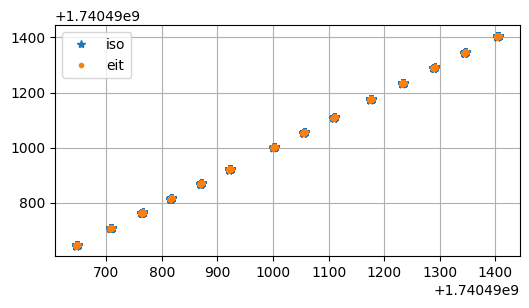

Export data (y) y


11 105
From: data/raw_data/P11/
To: data/prepared_data/P11/
Fund participant data:

Head directory: self.path='data/raw_data/P11/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P11/EIT_P11_raw_data_13012025045845.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P11/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P11/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P11/eit_raw/20250225 15.16.22/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P11/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


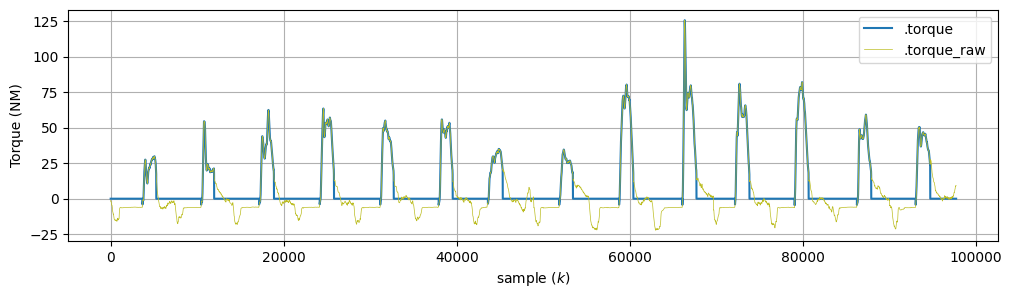

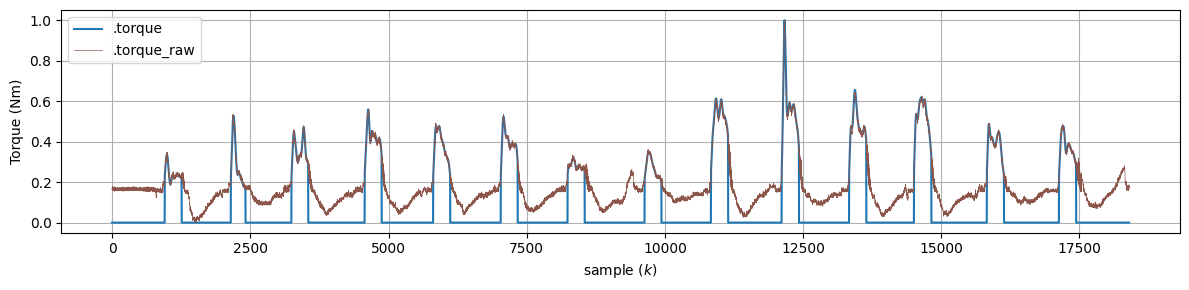

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=527, times_eit[sync_lst[0]]=1740492996.503
527 diff start: 0.006999969482421875 diff end: 0.006999969482421875
detected start idx valuessync_lst[0]=2766, times_eit[sync_lst[0]]=1740493052.475
2766 diff start: -0.004999876022338867 diff end: 0.009999990463256836
detected start idx valuessync_lst[0]=4844, times_eit[sync_lst[0]]=1740493104.423
4844 diff start: 0.006999969482421875 diff end: -0.011999845504760742
detected start idx valuessync_lst[0]=7014, times_eit[sync_lst[0]]=1740493158.67
7014 diff start: 0.009999990463256836 diff end: -0.003999948501586914
detected start idx valuessync_lst[0]=9390, times_eit[sync_lst[0]]=1740493218.066
9390 diff start: 0.003999948501586914 diff end: -0.0009999275207519531
detected start idx valuessync_lst[0]=11399, times_eit[sync_lst[0]]=1740493268.289
11399 diff start: 0.010999917984008789 diff end: 0.010999917984008789
detected start idx valuessync_lst[0]=13443, times_eit[sync_

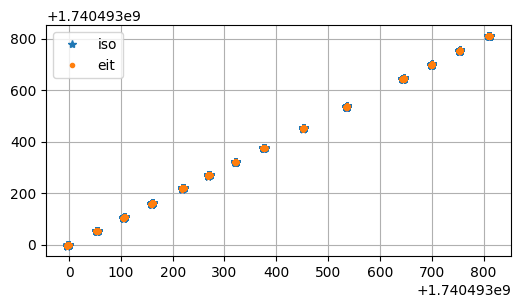

Export data (y) y


12 105
From: data/raw_data/P12/
To: data/prepared_data/P12/
Fund participant data:

Head directory: self.path='data/raw_data/P12/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P12/EIT_P12_raw_data_13012025063951.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P12/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P12/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P12/eit_raw/20250225 17.00.37/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P12/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


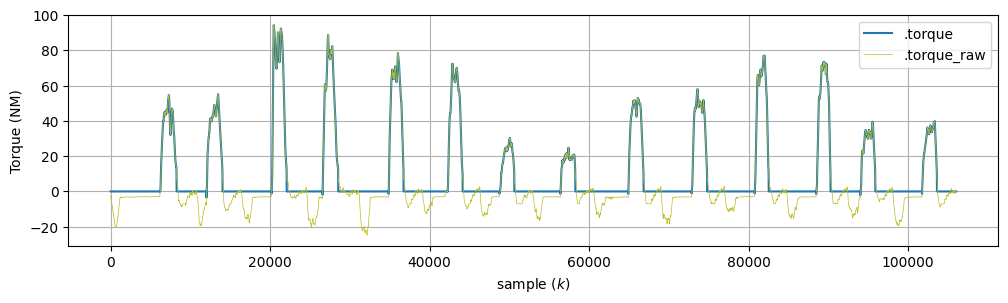

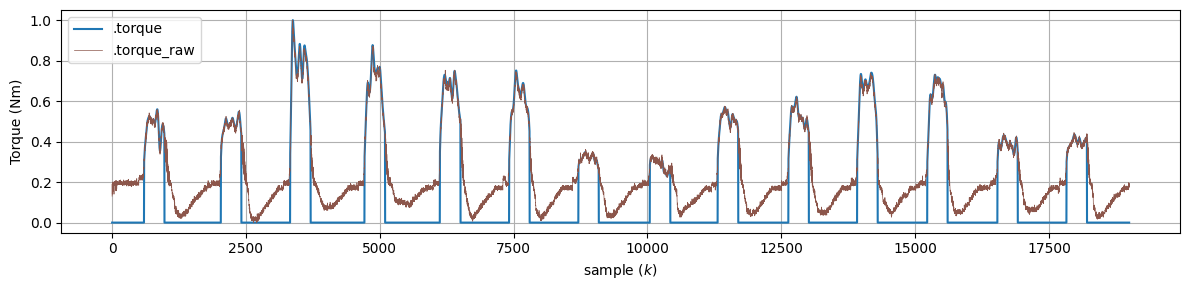

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=375, times_eit[sync_lst[0]]=1740499246.96
375 diff start: 0.0 diff end: -0.009000062942504883
detected start idx valuessync_lst[0]=3549, times_eit[sync_lst[0]]=1740499326.306
3549 diff start: 0.003999948501586914 diff end: -0.01100015640258789
detected start idx valuessync_lst[0]=5787, times_eit[sync_lst[0]]=1740499382.253
5787 diff start: -0.003000020980834961 diff end: 0.006999969482421875
detected start idx valuessync_lst[0]=7943, times_eit[sync_lst[0]]=1740499436.15
7943 diff start: -0.009999990463256836 diff end: -0.004999876022338867
detected start idx valuessync_lst[0]=10306, times_eit[sync_lst[0]]=1740499495.222
10306 diff start: -0.0019998550415039062 diff end: -0.012000083923339844
detected start idx valuessync_lst[0]=12424, times_eit[sync_lst[0]]=1740499548.17
12424 diff start: -0.009999990463256836 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=14621, times_eit[sync_lst[0]]=17404

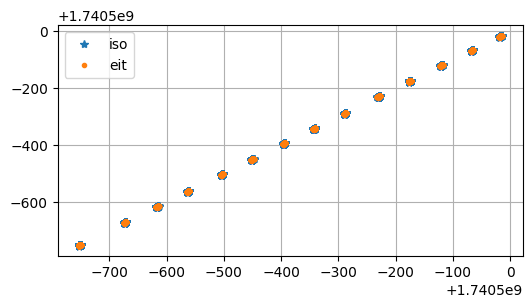

Export data (y) y


13 105
From: data/raw_data/P13/
To: data/prepared_data/P13/
Fund participant data:

Head directory: self.path='data/raw_data/P13/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P13/EIT_P13_raw_data_13012025082439.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P13/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P13/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P13/eit_raw/20250228 11.04.27/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P13/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


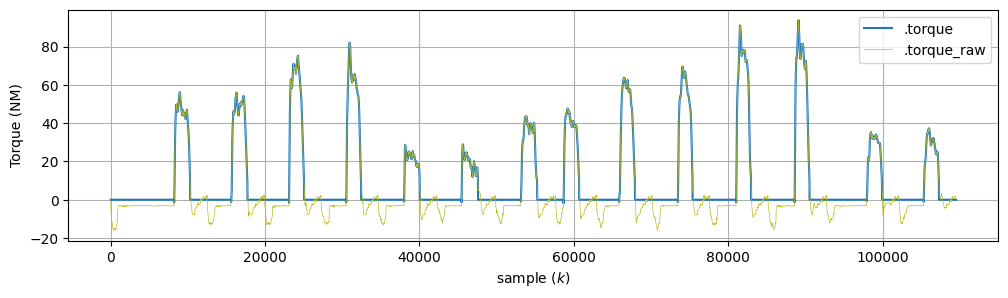

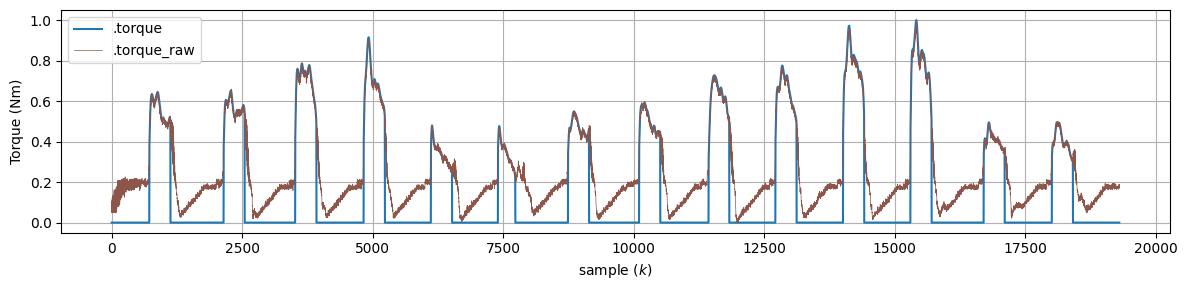

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=417, times_eit[sync_lst[0]]=1740737078.214
417 diff start: -0.003999948501586914 diff end: 0.0009999275207519531
detected start idx valuessync_lst[0]=2746, times_eit[sync_lst[0]]=1740737136.437
2746 diff start: 0.003000020980834961 diff end: -0.010999917984008789
detected start idx valuessync_lst[0]=4935, times_eit[sync_lst[0]]=1740737191.159
4935 diff start: -0.008999824523925781 diff end: -0.009000062942504883
detected start idx valuessync_lst[0]=6939, times_eit[sync_lst[0]]=1740737241.256
6939 diff start: 0.003999948501586914 diff end: 0.003999948501586914
detected start idx valuessync_lst[0]=9054, times_eit[sync_lst[0]]=1740737294.129
9054 diff start: 0.01100015640258789 diff end: 0.0010001659393310547
detected start idx valuessync_lst[0]=11128, times_eit[sync_lst[0]]=1740737345.976
11128 diff start: 0.003999948501586914 diff end: -0.01100015640258789
detected start idx valuessync_lst[0]=13305, times_eit[sync

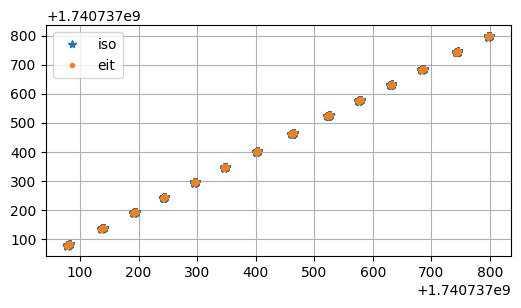

Export data (y) y


14 105
From: data/raw_data/P14/
To: data/prepared_data/P14/
Fund participant data:

Head directory: self.path='data/raw_data/P14/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P14/EIT_P14_raw_data_13012025090135.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P14/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P14/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P14/eit_raw/20250228 11.46.33/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P14/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


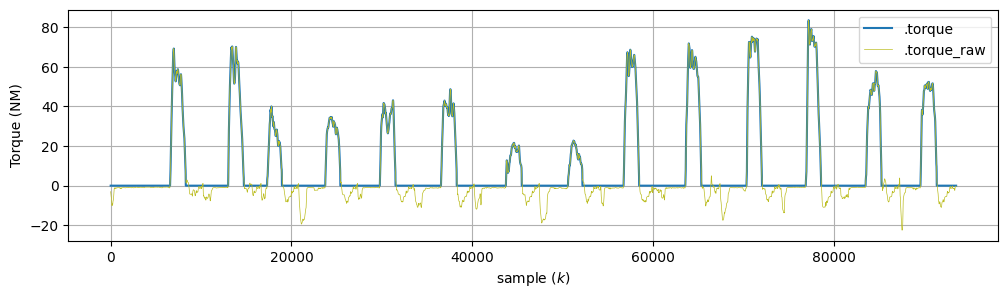

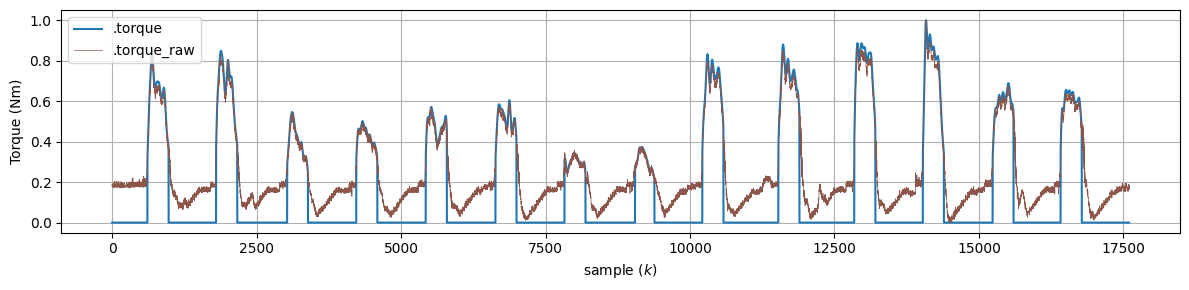

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=225, times_eit[sync_lst[0]]=1740739600.099
225 diff start: 0.010999917984008789 diff end: 0.012000083923339844
detected start idx valuessync_lst[0]=2741, times_eit[sync_lst[0]]=1740739662.995
2741 diff start: -0.004999876022338867 diff end: -0.004999876022338867
detected start idx valuessync_lst[0]=4873, times_eit[sync_lst[0]]=1740739716.292
4873 diff start: -0.002000093460083008 diff end: -0.011999845504760742
detected start idx valuessync_lst[0]=6871, times_eit[sync_lst[0]]=1740739766.24
6871 diff start: 0.009999990463256836 diff end: -0.009999990463256836
detected start idx valuessync_lst[0]=9792, times_eit[sync_lst[0]]=1740739839.261
9792 diff start: 0.009000062942504883 diff end: -0.0009999275207519531
detected start idx valuessync_lst[0]=11715, times_eit[sync_lst[0]]=1740739887.333
11715 diff start: 0.006999969482421875 diff end: 0.002000093460083008
detected start idx valuessync_lst[0]=13873, times_eit[syn

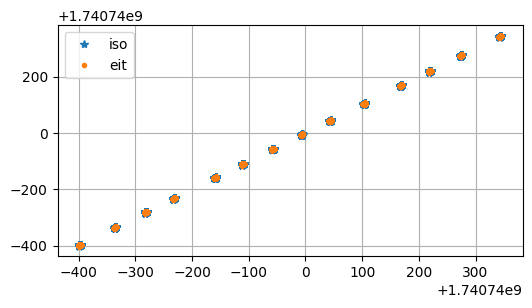

Export data (y) y


15 105
From: data/raw_data/P15/
To: data/prepared_data/P15/
Fund participant data:

Head directory: self.path='data/raw_data/P15/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P15/EIT_P15_raw_data_12012025091939.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P15/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P15/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P15/eit_raw/20250207 08.55.42/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P15/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


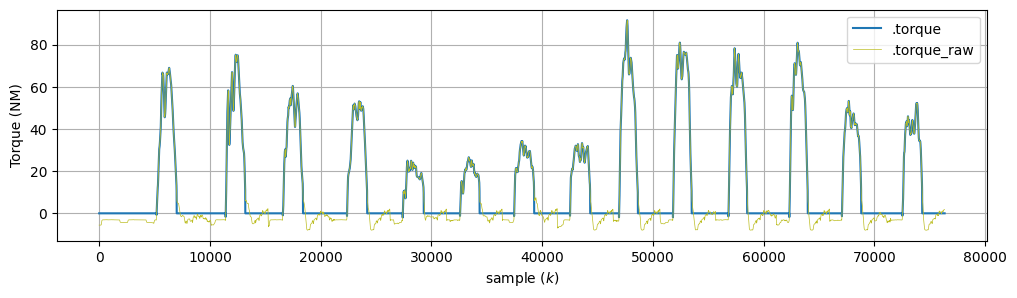

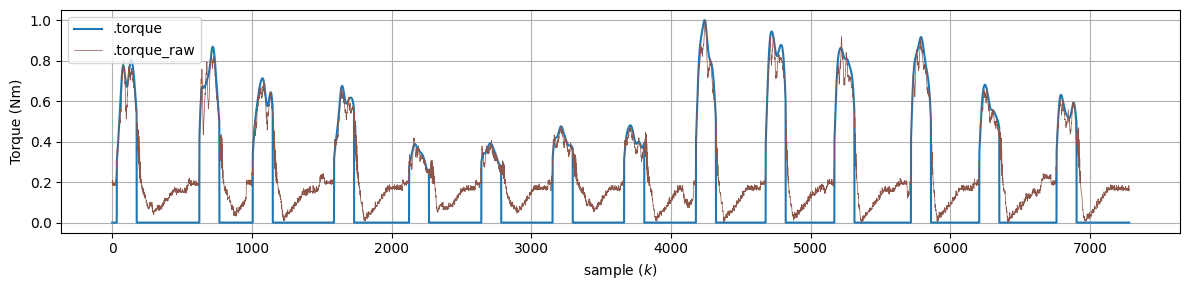

Loading eit...
Matching sequences...
detected start idx valuessync_lst[0]=155, times_eit[sync_lst[0]]=1738914946.847
155 diff start: 0.003000020980834961 diff end: 0.003000020980834961
detected start idx valuessync_lst[0]=2346, times_eit[sync_lst[0]]=1738915001.619
2346 diff start: 0.006000041961669922 diff end: 0.006000041961669922
detected start idx valuessync_lst[0]=4328, times_eit[sync_lst[0]]=1738915051.167
4328 diff start: 0.007999897003173828 diff end: 0.007999897003173828
detected start idx valuessync_lst[0]=6390, times_eit[sync_lst[0]]=1738915102.715
6390 diff start: 0.009999990463256836 diff end: 0.01100015640258789
detected start idx valuessync_lst[0]=8448, times_eit[sync_lst[0]]=1738915154.162
8448 diff start: -0.011999845504760742 diff end: -0.012000083923339844
detected start idx valuessync_lst[0]=10365, times_eit[sync_lst[0]]=1738915202.085
10365 diff start: -0.009999990463256836 diff end: -0.009000062942504883
detected start idx valuessync_lst[0]=12555, times_eit[sync_l

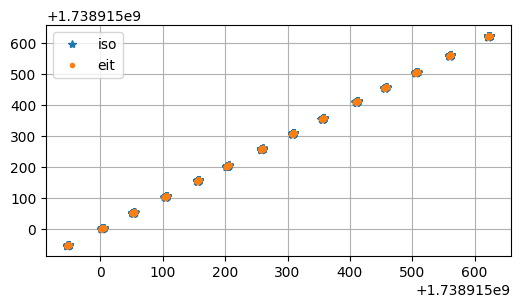

Export data (y) y


In [14]:
# available: [1,2,3,4,5,6]
# perfect: 3,4,5,6
# okay: 1,2

# thresholds minimum sequence distance

thlds = [20, 20, 100, 100, 100, 100, 105, 100, 105, 105, 105, 105, 105, 105, 105]
for p, t in zip([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], thlds):
    print(p, t)
    l_path = join("data/raw_data", "P{0:02d}/".format(p))
    s_path = join("data/prepared_data", "P{0:02d}/".format(p))
    print("From:", l_path)
    print("To:", s_path)
    try:
        os.mkdir(s_path)
    except BaseException:
        print("Already exist")
    part_path = ProcessingDir(l_path)  # SAVE
    protocol = Protocol(part_path.path, prints=False)  # SAVE

    DF = renderDF(part_path.isoforce_iso)
    isoforce_iso = IsoforceIso(DF, protocol, LP_filter=True)
    isoforce_iso.plot_torque()

    isoforce_py = IsoforcePy(
        part_path.isoforce_py_raw,
        protocol,
        LP_filter=True,
        over_UTC=False,
        scale_0_1=True,
        segment_len_threshold=t,
    )

    isoforce_py.plot_torque()

    assert len(isoforce_iso.torque_segments.keys()) == len(
        isoforce_py.torque_segments.keys()
    )

    EIT, TORQUE, TS_iso, TS_eit = sync_eit_ISO_segments(
        part_path, isoforce_iso, isoforce_py, plotting=False
    )
    assert TS_iso.shape[0] == TS_eit.shape[0]
    print(EIT.shape, TORQUE.shape, TS_iso.shape, TS_eit.shape)

    plt.figure(figsize=(6, 3))
    plt.plot(TS_iso, TS_iso, "*", label="iso")
    plt.plot(TS_eit, TS_eit, ".", label="eit")
    plt.legend()
    plt.grid()
    plt.show()

    if input("Export data (y)") == "y":
        for i in range(EIT.shape[0]):
            np.savez(
                join(s_path, "sample_{0:06d}.npz".format(i)),
                part_path=part_path,
                EIT=EIT[i],
                TORQUE=TORQUE[i],
                TS_eit=TS_eit[i],
                TS_iso=TS_iso[i],
                protocol=protocol,
            )
    else:
        print("Skipping:", s_path)

In [15]:
for ele in np.sort(glob("data/prepared_data/P*")):
    print(ele, len(os.listdir(ele)))

data/prepared_data/P01 2124
data/prepared_data/P02 4000
data/prepared_data/P03 4588
data/prepared_data/P04 4553
data/prepared_data/P05 5161
data/prepared_data/P06 5383
data/prepared_data/P07 4238
data/prepared_data/P09 5196
data/prepared_data/P10 5063
data/prepared_data/P11 4278
data/prepared_data/P12 5344
data/prepared_data/P13 5577
data/prepared_data/P14 5067
data/prepared_data/P15 2001


**Statistics**

In [16]:
tmp = np.load("data/prepared_data/P03/sample_000000.npz", allow_pickle=True)
tmp.files

['part_path', 'EIT', 'TORQUE', 'TS_eit', 'TS_iso', 'protocol']

In [27]:
from tools import load_data, compute_PCA

**Try different normalization approaches**

- global z-score normalization of all EIT data values
- normalize the EIT data of each individual patient
- substract the mean of all EIT values of a patient from the EIT data and normalize the EIT data for each individual patient

In [28]:
part_list = [_ for _ in range(1, 16)]
X, y, p = load_data(part_list, z_score_norm="global")

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
before: 0.09357920800443108 0.09224069287090296
after global: 5.041396076265785e-16 1.0000000000000009


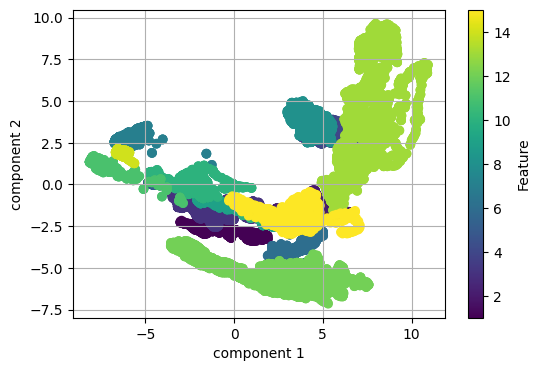

In [29]:
compute_PCA(np.abs(X.reshape(X.shape[0], X.shape[1] * X.shape[1])), feature=p)

In [30]:
X, y, p = load_data(part_list, z_score_norm="participant")

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
before: 0.10121047447973297 0.08559029670399013
after global: -1.1332219950034554e-16 0.9999999999999999
before: 0.11185415178259897 0.10589884193031607
after global: 8.887335312124378e-17 1.0000000000000002
before: 0.0800117419681944 0.07692636541786035
after global: 1.7393816697919845e-16 0.9999999999999998
before: 0.11716212306352751 0.11211384344226417
after global: -6.001007826932814e-17 0.9999999999999999
before: 0.09518560221320055 0.0835836728051198
after global: 4.798202783232729e-16 1.0000000000000002
before: 0.1195219613317615 0.09810087940561606
after global: 7.184997122211885e-16 0.9999999999999997
before: 0.07902635244468481 0.0647451708329908
after global: 4.090378080815761e-16 1.0000000000000002
before: 0.09518241867065386 0.10935095920154655
after global: 6.196286377023384e-17 1.0000000000000002
before: 0.09597812428830929 0.08134455658468787
after global: -5

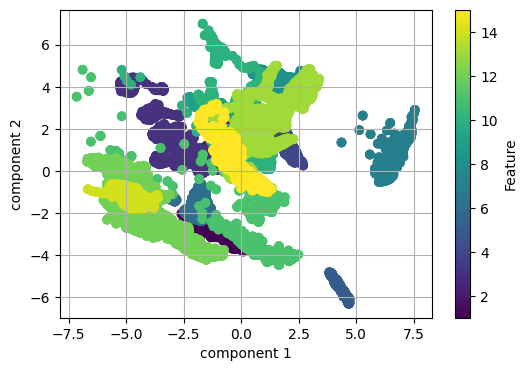

In [31]:
compute_PCA(np.abs(X.reshape(X.shape[0], X.shape[1] * X.shape[1])), feature=p)

In [32]:
X, y, p = load_data(part_list, z_score_norm="participant_meanfree")

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.014157458413294332 0.019697427174936128
after global: 5.144634718234897e-16 0.9999999999999999
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.01421073297731075 0.016707890764832815
after global: -1.4497636640483996e-16 0.9999999999999998
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487

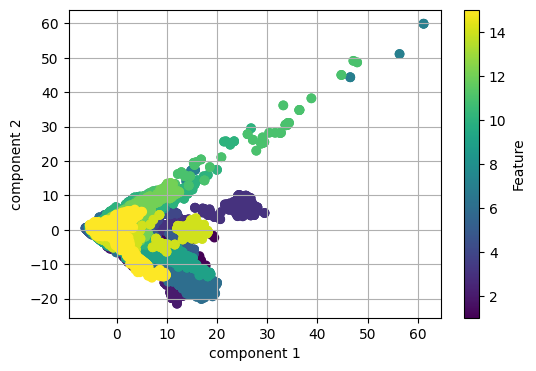

In [33]:
compute_PCA(np.abs(X.reshape(X.shape[0], X.shape[1] * X.shape[1])), feature=p)

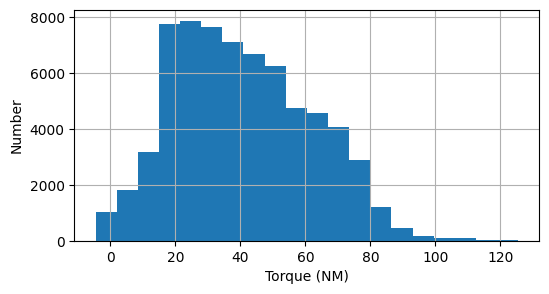

In [35]:
plt.figure(figsize=(6, 3))
plt.hist(y, bins=20)
plt.ylabel("Number")
plt.xlabel("Torque (NM)")
plt.grid()
plt.show()

___